# FINAL PROJECT: ISM 6562 - BIG DATA FOR BUSINESS

## **Setup Steps**

> ⚠️ **Note:** You must have a Java Development Kit (JDK) installed and the `JAVA_HOME` environment variable correctly configured.

- **For Windows**: The stable JDK version as of May 3, 2025, is **Java 11**.  
- **For macOS**: The stable version is **Java 17**, available from [Adoptium](https://adoptium.net/).

### 📦 Ensure All Required Packages Are Installed
Automatically installs missing Python packages using pip. This is useful for making your notebook portable and reproducible on other systems.

In [2]:
import importlib.util
import subprocess
import sys

# List of packages to ensure are installed
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "ucimlrepo",
    "pyspark",
    "sklearn",       # scikit-learn's import name is 'sklearn'
    "findspark"
]

for package in packages:
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")


numpy is already installed.
pandas is already installed.
matplotlib is already installed.
seaborn is already installed.
ucimlrepo is already installed.
pyspark is already installed.
sklearn is already installed.
findspark is already installed.


### 📚 Import Libraries
Load all necessary Python and PySpark libraries for data manipulation, visualization, and machine learning pipeline construction.

In [3]:
# Importing libraries
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StandardScaler, PCA

sns.set_theme(palette="viridis")

### ⚙️ Initialize Spark and Confirm Environment
Finds and initializes the Spark environment using `findspark`, printing the Spark installation path to confirm.

In [4]:
findspark.init() 
# If you have a SPARK_HOME environment variable set, it might find it automatically
spark_path = findspark.find()
print(spark_path)

/Applications/miniconda3/lib/python3.12/site-packages/pyspark


### 📥 Load UCI Communities and Crime Dataset
Fetches dataset #183 from the UCI ML repository using `ucimlrepo`, and combines the features and target into a single pandas DataFrame.

In [5]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 

# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

df = pd.concat([X, y], axis=1)

## 🧮 **Data Loading & Session Setup**

### 🔌 Initialize Spark Session
Starts a new Spark session which allows running distributed computations on the dataset.

In [6]:
spark = SparkSession.builder.appName("CommunitiesCrime").getOrCreate()

25/05/05 16:45:15 WARN Utils: Your hostname, Tras-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.16.79.29 instead (on interface en0)
25/05/05 16:45:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 16:45:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 🔄 Prepare Spark SQL Table
Converts the pandas DataFrame to a Spark DataFrame and registers it as a temporary SQL table named `raw_crime`.

In [7]:
spark_df = spark.createDataFrame(df)
spark_df.show()

25/05/05 16:45:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+------+---------+--------------------+----+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+----------

In [8]:
spark_df.createOrReplaceTempView("raw_crime")

### 🧼 Clean Missing or Placeholder Values
Replaces any `'?'` string values with `NULL` using Spark SQL's `NULLIF` function, enabling safe type casting and filtering later.

In [9]:
columns = spark_df.columns

sql_expr = ",\n".join(
    [f"NULLIF({col}, '?') AS {col}" for col in columns]
)

query = f"SELECT {sql_expr} FROM raw_crime"
clean_df = spark.sql(query)
clean_df.createOrReplaceTempView("clean_crime")

## 🧹 **Data Cleaning & Casting**

### 🗃 Preserve State Info for Later Ranking
Creates a smaller DataFrame containing only `state` and `ViolentCrimesPerPop` to be joined back later for state-wise ranking analysis.

In [10]:
#Perserving "State" and "ViolentCrimes" references for use later in further data manipulation
state_df = clean_df.select("state", "ViolentCrimesPerPop")

### 🗑 Drop Irrelevant Identifier Columns
Removes columns like `state`, `county`, and `communityname` that are not useful for modeling. The goal is to retain only meaningful numeric features.

In [11]:
cols_to_drop = ["state", "county", "community", "communityname", "fold"]
selected_cols = [c for c in clean_df.columns if c not in cols_to_drop]
clean_df = clean_df.select(*selected_cols)
clean_df.createOrReplaceTempView("final_crime")

### 🔢 Convert Columns to Numeric Types
Casts all remaining columns to `DOUBLE` type for compatibility with machine learning operations in PySpark (e.g., VectorAssembler, PCA).

In [12]:
numeric_cast_expr = ",\n".join(
    [f"CAST({col} AS DOUBLE) AS {col}" for col in selected_cols]
)
spark.sql(f"SELECT {numeric_cast_expr} FROM final_crime").createOrReplaceTempView("tidy_crime")

casted_df = spark.sql(f"SELECT {numeric_cast_expr} FROM final_crime")
casted_df.createOrReplaceTempView("tidy_crime")

### 🧽 Final Tidy Dataset
Displays the cleaned and fully numeric dataset. This Spark DataFrame is now ready for vectorization and modeling.

In [13]:
# This is your clean, tidy, and numeric Spark DataFrame
tidy_df = spark.sql("SELECT * FROM tidy_crime")
tidy_df.show()

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

## 🔧 **Feature Engineering Pipeline**

### ⚙️ Assemble Features for Modeling
Use case: Combine multiple numeric features into a single vector column named `features` using `VectorAssembler`, while skipping over any invalid entries.

Why it's useful: This is a prerequisite for feeding data into ML models like linear regression or random forest.

In [14]:
# Drop all rows that contain nulls in any feature
feature_cols = [c for c in tidy_df.columns if c != "ViolentCrimesPerPop"]

# Then assemble
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

### ⚖️ Normalize Feature Vectors
Use case: Normalize the `features` column using `StandardScaler` so each feature has zero mean and unit variance, improving model performance.

Why it's useful: Helps gradient-based models like logistic regression or linear regression converge better.

In [15]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
pca = PCA(k=20, inputCol='scaledFeatures', outputCol='pcaFeatures')

### 🔽 Apply PCA (Principal Component Analysis) for Dimensionality Reduction
Use case: Reduces the number of input features by projecting them into 20 principal components using PCA, which captures most of the variance..

Why it's useful: The dataset has 100+ features, many of which are correlated.

In [16]:
pipeline = Pipeline(stages=[assembler, scaler, pca])
model = pipeline.fit(tidy_df)
result_df = model.transform(tidy_df)

25/05/05 16:45:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/05 16:45:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### 📦 Show PCA Output and Cache Transformed Dataset

Use case: Displays the result of the PCA transformation and caches the resulting DataFrame for faster subsequent queries.

Why it's useful: Good vor visualizing the values with PCA transformation

In [17]:
result_df.select("pcaFeatures").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                                                                                                                                                                                                                                                                                                                      |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
result_df.cache()

DataFrame[population: double, householdsize: double, racepctblack: double, racePctWhite: double, racePctAsian: double, racePctHisp: double, agePct12t21: double, agePct12t29: double, agePct16t24: double, agePct65up: double, numbUrban: double, pctUrban: double, medIncome: double, pctWWage: double, pctWFarmSelf: double, pctWInvInc: double, pctWSocSec: double, pctWPubAsst: double, pctWRetire: double, medFamInc: double, perCapInc: double, whitePerCap: double, blackPerCap: double, indianPerCap: double, AsianPerCap: double, OtherPerCap: double, HispPerCap: double, NumUnderPov: double, PctPopUnderPov: double, PctLess9thGrade: double, PctNotHSGrad: double, PctBSorMore: double, PctUnemployed: double, PctEmploy: double, PctEmplManu: double, PctEmplProfServ: double, PctOccupManu: double, PctOccupMgmtProf: double, MalePctDivorce: double, MalePctNevMarr: double, FemalePctDiv: double, TotalPctDiv: double, PersPerFam: double, PctFam2Par: double, PctKids2Par: double, PctYoungKids2Par: double, PctTeen2P

## 📊 **Visual Exploration**

### 📉 Generate Correlation Heatmap
Computes and visualizes the correlation matrix of features in a 20% sample of the dataset. This helps identify multicollinearity and feature relevance.

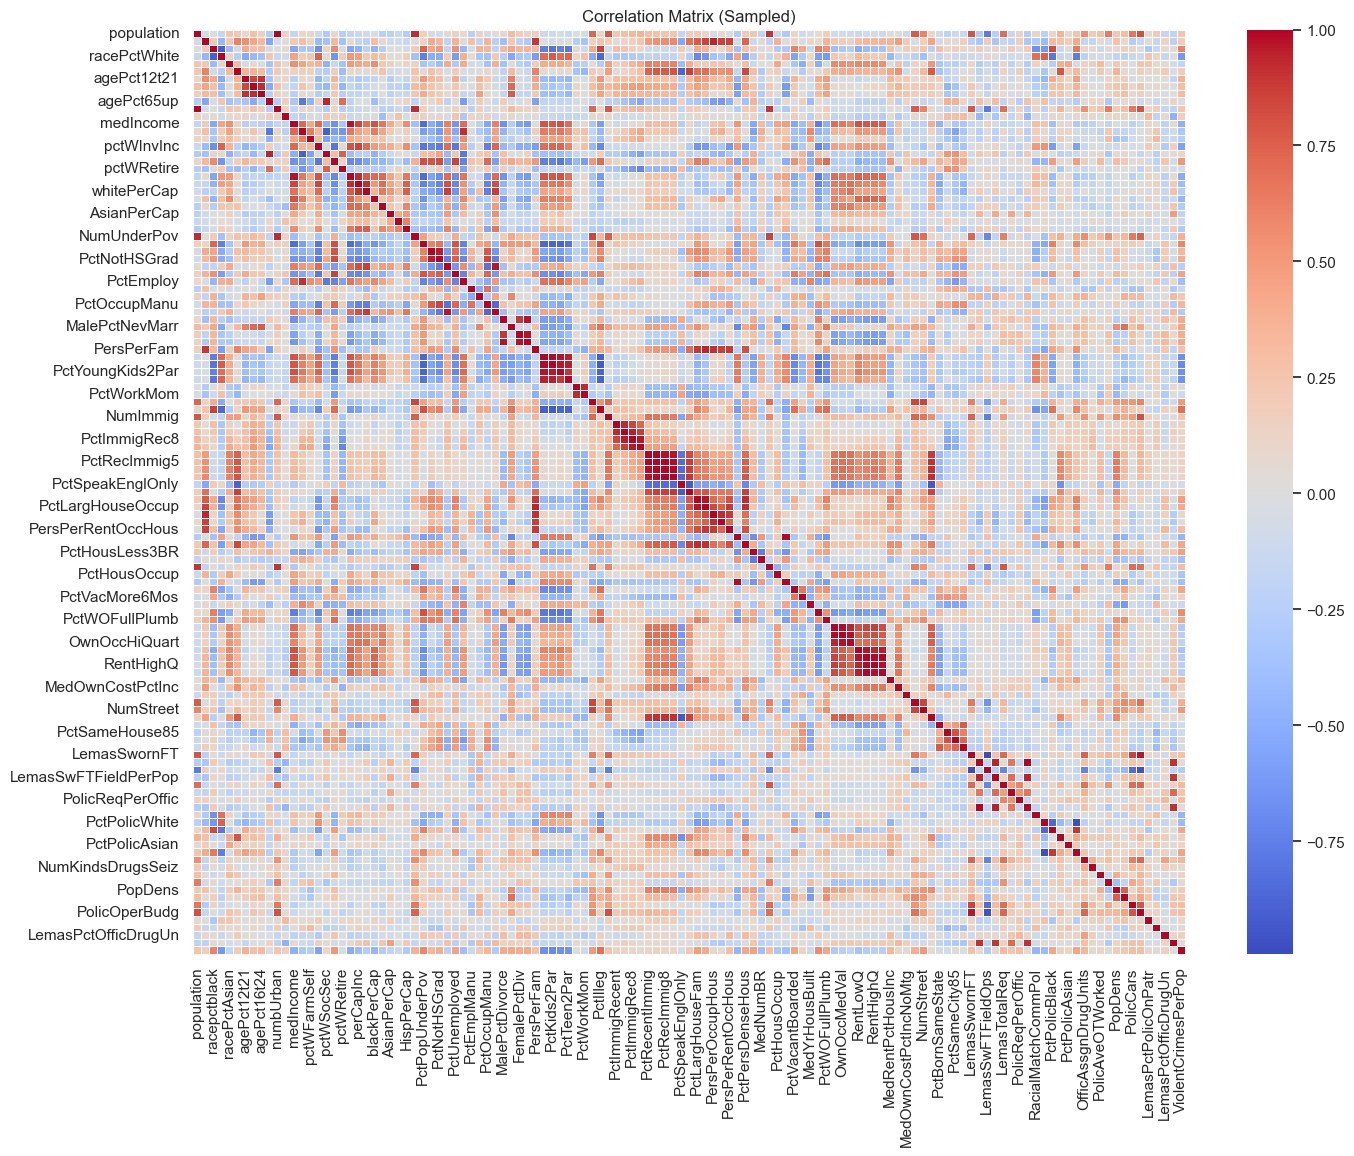

In [19]:
# Convert Spark DataFrame to Pandas
sample_pd_df = tidy_df.sample(False, 0.2, seed=42).toPandas()  # Sample 20% to avoid memory overload

# Drop any remaining nulls
sample_pd_df.dropna(inplace=True)

# ===========================
# 📊 Correlation Heatmap
# ===========================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
corr_matrix = sample_pd_df.corr(numeric_only=True)

sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Sampled)")
plt.show()


### 🧮 Visualize Crime Rate Distribution
Displays the frequency distribution of the target variable `ViolentCrimesPerPop` using a histogram with a KDE overlay.

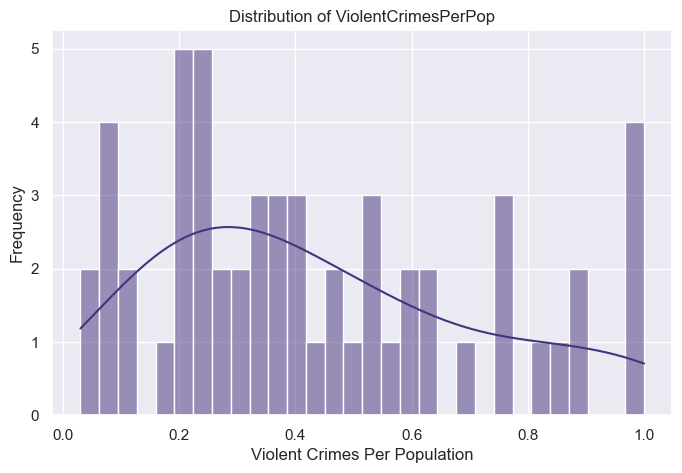

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(sample_pd_df['ViolentCrimesPerPop'], bins=30, kde=True)
plt.title("Distribution of ViolentCrimesPerPop")
plt.xlabel("Violent Crimes Per Population")
plt.ylabel("Frequency")
plt.show()


### 📦 Income Distribution by Crime Level
Visualizes how median income varies across binned crime levels (Low, Medium, High) using a boxplot.

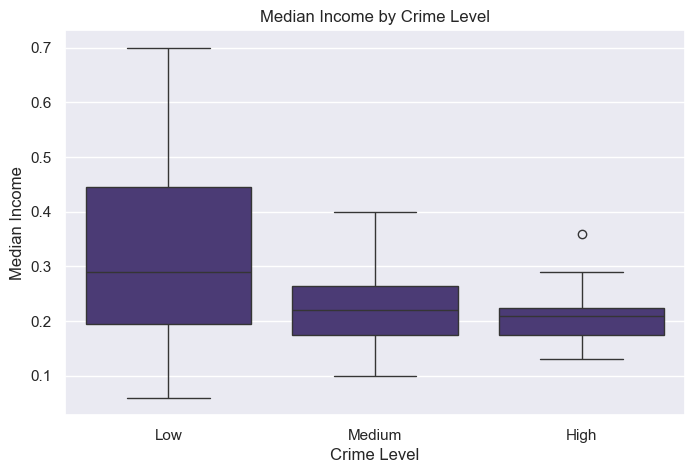

In [21]:
# Create 'crime_level' bin again for pandas
sample_pd_df["crime_level"] = pd.cut(
    sample_pd_df["ViolentCrimesPerPop"],
    bins=[0, 0.4, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

plt.figure(figsize=(8, 5))
sns.boxplot(x="crime_level", y="medIncome", data=sample_pd_df)
plt.title("Median Income by Crime Level")
plt.xlabel("Crime Level")
plt.ylabel("Median Income")
plt.show()


### 📈 Scatterplot: Poverty vs Crime
Shows the relationship between poverty rate and violent crime rate using a scatter plot to identify possible trends or clusters.

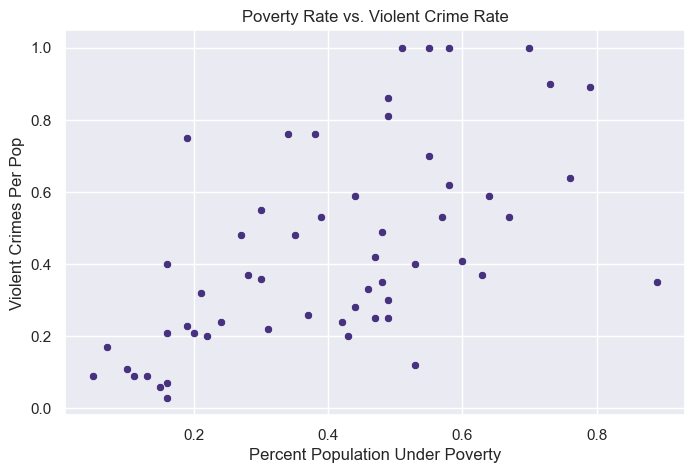

In [22]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="PctPopUnderPov", y="ViolentCrimesPerPop", data=sample_pd_df)
plt.title("Poverty Rate vs. Violent Crime Rate")
plt.xlabel("Percent Population Under Poverty")
plt.ylabel("Violent Crimes Per Pop")
plt.show()


## 📊 **SQL-Based Analysis**

### 🧮 Create SQL View for Result DataFrame
Registers the final transformed DataFrame as a temporary SQL view to enable SQL queries for further analysis.

In [23]:
# Create a SQL view from result_df
result_df.createOrReplaceTempView("final_result")

### 🧱 Bin Crime Levels in SQL
Adds a new column `crime_level` by categorizing the `ViolentCrimesPerPop` variable into High, Medium, or Low for easier group analysis.

In [24]:
# Create binned crime levels
spark.sql("""
    SELECT *,
        CASE 
            WHEN ViolentCrimesPerPop >= 0.7 THEN 'High'
            WHEN ViolentCrimesPerPop >= 0.4 THEN 'Medium'
            ELSE 'Low'
        END AS crime_level
    FROM final_result
""").createOrReplaceTempView("binned_result")

### 📊 Summary Stats by Crime Level
Aggregates key socioeconomic indicators (income, poverty, police budget) by crime level to find patterns across different crime intensities.

In [25]:
# Analyze poverty vs crime_level
spark.sql("""
    SELECT crime_level,
        COUNT(*) AS total_communities,
        ROUND(AVG(medIncome), 0) AS avg_median_income,
        ROUND(AVG(PctPopUnderPov), 2) AS avg_pct_under_poverty,
        ROUND(AVG(PolicOperBudg), 2) AS avg_police_budget
    FROM binned_result
    GROUP BY crime_level
    ORDER BY crime_level
""").show()

+-----------+-----------------+-----------------+---------------------+-----------------+
|crime_level|total_communities|avg_median_income|avg_pct_under_poverty|avg_police_budget|
+-----------+-----------------+-----------------+---------------------+-----------------+
|       High|               62|              0.0|                 0.55|             0.15|
|        Low|              160|              0.0|                 0.29|             0.03|
|     Medium|               97|              0.0|                 0.46|              0.1|
+-----------+-----------------+-----------------+---------------------+-----------------+



### 🔟 Top 10 Poorest, Most Violent Communities
Lists the top 10 communities with the highest poverty and violent crime rates to highlight potential areas of concern.

In [26]:
spark.sql("""
    SELECT *
    FROM tidy_crime
    WHERE PctPopUnderPov IS NOT NULL AND ViolentCrimesPerPop IS NOT NULL
    ORDER BY PctPopUnderPov DESC, ViolentCrimesPerPop DESC
    LIMIT 10
""").show(truncate=False)

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

### 🧭 Crime Rankings by State
Reattaches the preserved `state` column and ranks communities within each state by their violent crime rate using Spark SQL's window functions.

In [27]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row indices to join safely
with_state = tidy_df.withColumn("row_id", monotonically_increasing_id())
with_state_info = state_df.withColumn("row_id", monotonically_increasing_id())
with_state_info = with_state_info.drop("ViolentCrimesPerPop")

# Reattach 'state'
final_df = with_state.join(with_state_info, on="row_id").drop("row_id")
final_df.createOrReplaceTempView("final_with_state")


In [28]:
spark.sql("""
    SELECT *, 
        RANK() OVER (PARTITION BY state ORDER BY ViolentCrimesPerPop DESC) AS crime_rank_in_state
    FROM final_with_state
""").createOrReplaceTempView("crime_ranks_by_state")

spark.sql("""
    SELECT * FROM crime_ranks_by_state
    WHERE crime_rank_in_state = 1
""").show(truncate=False)

+----------+-------------+------------+------------+------------+-----------+-----------+-----------+-----------+----------+---------+--------+---------+--------+------------+----------+----------+-----------+----------+---------+---------+-----------+-----------+------------+-----------+-----------+----------+-----------+--------------+---------------+------------+-----------+-------------+---------+-----------+---------------+------------+----------------+--------------+--------------+------------+-----------+----------+----------+-----------+----------------+-----------+-------------------+----------+--------+--------+--------+--------------+------------+------------+-------------+--------------+------------+------------+-------------+----------------+-------------------+---------------+-----------------+----------------+-----------------+------------------+---------------+----------------+--------------+--------+----------+------------+-------------+----------------+--------------+

## SparkML Analysis

### 🚀 Model Training and Evaluation

We implemented four regression models using SparkML to predict violent crime rates:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient-Boosted Trees Regressor

We evaluated model performance using Root Mean Squared Error (RMSE) on a held-out test set.

### 🛠 Data Split and Evaluator

We split the dataset into training (80%) and testing (20%) sets to evaluate model performance.  
We also defined a regression evaluator using RMSE (Root Mean Squared Error) as our main metric.

In [ ]:
# Import SparkML regression models and evaluator
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Split the dataset into training (80%) and testing (20%) sets
train_df, test_df = result_df.randomSplit([0.8, 0.2], seed=42)

# Initialize the regression evaluator with RMSE metric
evaluator = RegressionEvaluator(
    labelCol="ViolentCrimesPerPop",    
    predictionCol="prediction",       
    metricName="rmse"                  
)

### 🚀 Train and Evaluate Models

We trained four models and evaluated their performance on the test set.  
For each model, we computed the RMSE and printed the results.

In [34]:
# Define the four regression models to evaluate
models = {
    "Linear Regression": LinearRegression(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop'),
    "Decision Tree Regressor": DecisionTreeRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop'),
    "Random Forest Regressor": RandomForestRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop'),
    "Gradient Boosted Trees": GBTRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop')
}

# Prepare a list to store model names and RMSE scores
results = []

# Loop over each model, train, predict, and evaluate
for name, model in models.items():
    fitted_model = model.fit(train_df)
    test_predictions = fitted_model.transform(test_df)
    test_rmse = evaluator.evaluate(test_predictions)
    
    train_predictions = fitted_model.transform(train_df)
    train_rmse = evaluator.evaluate(train_predictions)
    
    results.append((name, train_rmse, test_rmse))
    print(f"{name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")


25/05/05 17:11:28 WARN Instrumentation: [a77e8862] regParam is zero, which might cause numerical instability and overfitting.


Linear Regression - Train RMSE: 0.1549, Test RMSE: 0.1729
Decision Tree Regressor - Train RMSE: 0.1253, Test RMSE: 0.2474
Random Forest Regressor - Train RMSE: 0.1313, Test RMSE: 0.1978
Gradient Boosted Trees - Train RMSE: 0.0278, Test RMSE: 0.2516


### 📊 Step 3: Summarize Model Performance

We summarized the RMSE scores in a sorted table to easily identify the best-performing model.

In [35]:
# Import pandas for creating a summary table
import pandas as pd

summary_df = pd.DataFrame(results, columns=['Model', 'Train_RMSE', 'Test_RMSE'])
print(summary_df)

                     Model  Train_RMSE  Test_RMSE
0        Linear Regression    0.154872   0.172890
1  Decision Tree Regressor    0.125289   0.247386
2  Random Forest Regressor    0.131265   0.197840
3   Gradient Boosted Trees    0.027761   0.251578


### ⚙️ Advanced SparkML Features

We implemented:
- Cross-validation + hyperparameter tuning for Linear Regression using `CrossValidator` and `ParamGridBuilder`.
- Feature importance extraction for Random Forest to interpret which PCA components influence predictions the most.

These advanced techniques improve model robustness and interpretability.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Linear Regression model
lr = LinearRegression(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop')

# Build parameter grid to test different regularization values
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up 3-fold cross-validator
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

# Run cross-validation on training set
cv_model = cv.fit(train_df)

# Evaluate the best model on the test set
cv_predictions = cv_model.transform(test_df)
cv_rmse = evaluator.evaluate(cv_predictions)

print(f"\nBest Linear Regression (CV) RMSE: {cv_rmse:.4f}")



Best Linear Regression (CV) RMSE: 0.1739


### 🔎 Feature Importance and Coefficients

We extracted:
- Decision Tree, Random Forest, and Gradient Boosted Trees feature importances on PCA components.
- Linear Regression coefficients on PCA components.

Since we used PCA, importances and coefficients apply to principal components, not the original features.

In [ ]:
# Decision Tree Regressor
dt_model = DecisionTreeRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
dt_importances = dt_model.featureImportances.toArray()
dt_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(dt_importances))],
    'Importance': dt_importances
}).sort_values('Importance', ascending=False)
print("\nDecision Tree Feature Importances:")
print(dt_df)

# Random Forest Regressor
rf_model = RandomForestRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
rf_importances = rf_model.featureImportances.toArray()
rf_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(rf_importances))],
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importances:")
print(rf_df)

# Gradient Boosted Trees Regressor
gbt_model = GBTRegressor(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
gbt_importances = gbt_model.featureImportances.toArray()
gbt_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(gbt_importances))],
    'Importance': gbt_importances
}).sort_values('Importance', ascending=False)
print("\nGradient Boosted Trees Feature Importances:")
print(gbt_df)

# Linear Regression Coefficients (note: only meaningful without PCA)
lr_model = LinearRegression(featuresCol='pcaFeatures', labelCol='ViolentCrimesPerPop').fit(train_df)
lr_coefficients = lr_model.coefficients.toArray()
lr_df = pd.DataFrame({
    'PCA Component': [f'PC{i+1}' for i in range(len(lr_coefficients))],
    'Coefficient': lr_coefficients
}).sort_values('Coefficient', key=abs, ascending=False)
print("\nLinear Regression Coefficients (on PCA components):")
print(lr_df)



Decision Tree Feature Importances:
   PCA Component  Importance
0            PC1    0.657620
7            PC8    0.100256
4            PC5    0.063508
10          PC11    0.047029
3            PC4    0.032830
12          PC13    0.025616
8            PC9    0.019512
9           PC10    0.017764
6            PC7    0.012931
14          PC15    0.012772
17          PC18    0.006148
1            PC2    0.002103
18          PC19    0.001912
5            PC6    0.000000
2            PC3    0.000000
11          PC12    0.000000
13          PC14    0.000000
15          PC16    0.000000
16          PC17    0.000000
19          PC20    0.000000

Random Forest Feature Importances:
   PCA Component  Importance
0            PC1    0.453678
7            PC8    0.063657
4            PC5    0.049686
2            PC3    0.048561
6            PC7    0.035144
1            PC2    0.034300
3            PC4    0.033603
16          PC17    0.029275
19          PC20    0.029104
8            PC9    0.027837


25/05/05 16:52:06 WARN Instrumentation: [8c358015] regParam is zero, which might cause numerical instability and overfitting.



Linear Regression Coefficients (on PCA components):
   PCA Component  Coefficient
0            PC1    -0.037946
7            PC8    -0.029872
19          PC20    -0.029159
6            PC7    -0.019301
4            PC5    -0.015815
2            PC3     0.015737
17          PC18     0.012305
15          PC16    -0.009263
11          PC12     0.008385
1            PC2     0.007632
10          PC11     0.007556
18          PC19     0.007490
12          PC13     0.007377
13          PC14    -0.006159
3            PC4     0.006138
8            PC9    -0.004074
16          PC17    -0.003242
9           PC10    -0.003214
5            PC6     0.001054
14          PC15    -0.000410
